## Importing the relevant libraries

In [1]:
import torch, time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [2]:
if torch.cuda.is_available():
    print("Device:",torch.cuda.current_device())
    print("Device Name:",torch.cuda.get_device_name())

Device: 0
Device Name: Tesla T4


## Loading the dataset

In [3]:
img_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.4),
    transforms.RandomVerticalFlip(0.3),
    transforms.Resize((240,240)),
    transforms.CenterCrop((240,240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
img_transforms

Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.4)
    RandomVerticalFlip(p=0.3)
    Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(240, 240))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [4]:
data_dir = "/kaggle/input/weather-dataset/dataset"

dataset = datasets.ImageFolder(root=data_dir,transform=img_transforms)

In [5]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [6]:
len(dataset)

6862

## Splitting the dataset into train and test sets

In [7]:
train_set, test_set = random_split(dataset=dataset,lengths=[0.8,0.2])

## Dividing the train and test datasets into batches using DataLoader

In [8]:
train_loader = DataLoader(dataset=train_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")
test_loader = DataLoader(dataset=test_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")

## Visualizing a sample of the images within the dataset

In [9]:
for images, labels in train_loader:
    break

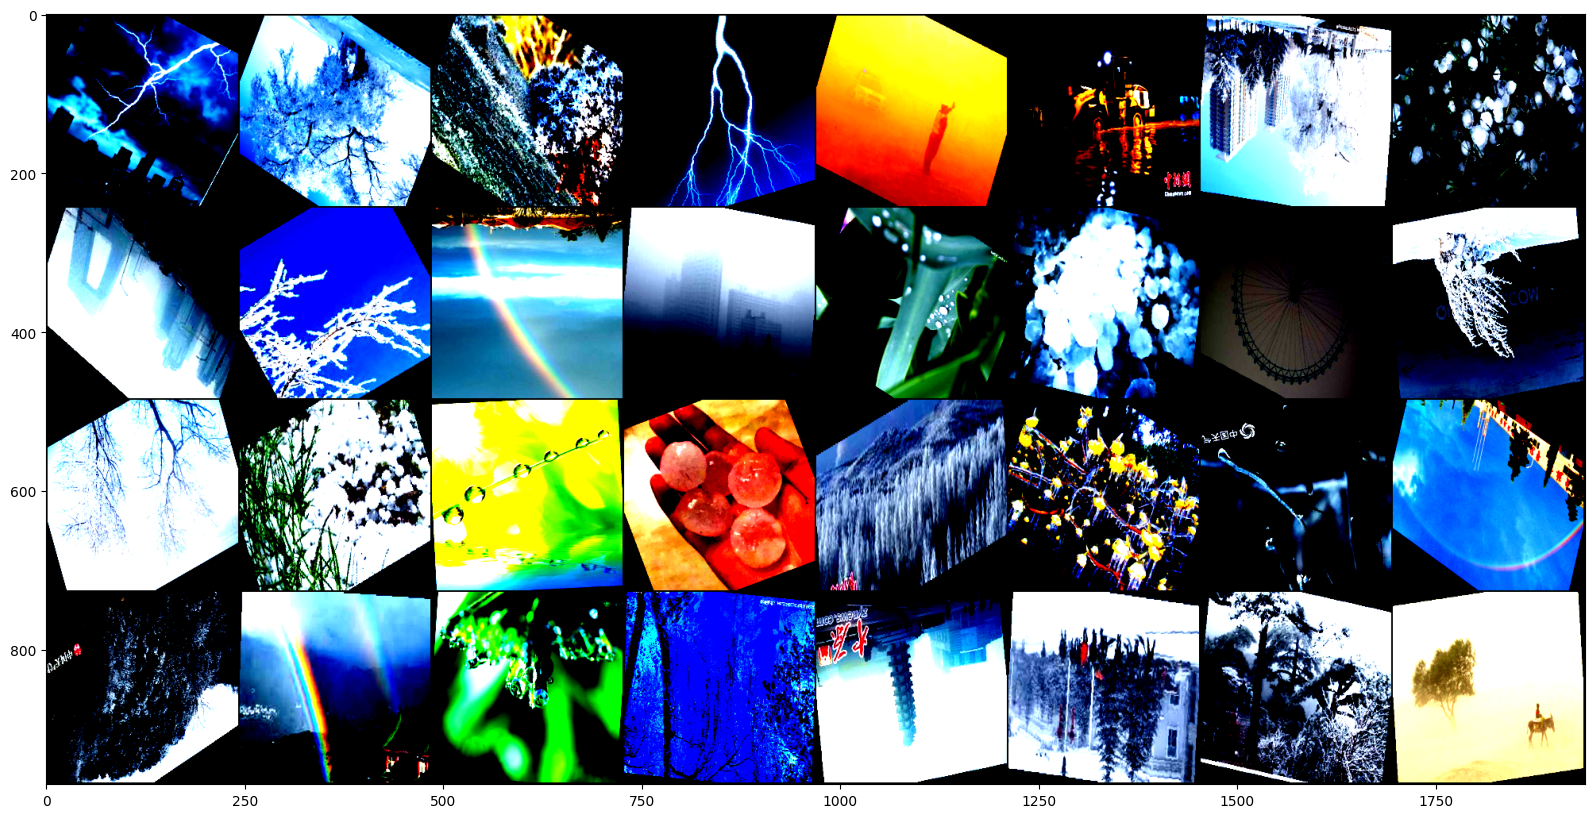

In [10]:
img_grid = make_grid(images,nrow=8)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_normalized_images = inv_normalize(images)

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(img_grid.numpy(),(1,2,0)));

In [11]:
images.shape

torch.Size([32, 3, 240, 240])

## Model Training & Evaluation

In [12]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1) # 119,119,64
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1) # 58,58,128
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1) # 28,28,256
        self.conv4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1) # 13,13,512
        self.fc1 = nn.Linear(in_features=13*13*512,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=256)
        self.fc3 = nn.Linear(in_features=256,out_features=128)
        self.fc4 = nn.Linear(in_features=128,out_features=64)
        self.fc5 = nn.Linear(in_features=64,out_features=32)
        self.fc6 = nn.Linear(in_features=32,out_features=11)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,13*13*512)
        X = F.relu(self.fc1(X))
        X = F.dropout(X,p=0.45)
        X = F.relu(self.fc2(X))
        X = F.dropout(X,p=0.35)
        X = F.relu(self.fc3(X))
        X = F.dropout(X,p=0.25)
        X = F.relu(self.fc4(X))
        X = F.dropout(X,p=0.2)
        X = F.relu(self.fc5(X))
        X = F.dropout(X,p=0.1)
        X = self.fc6(X)
        return F.log_softmax(X,dim=1)

In [13]:
torch.manual_seed(48)
model = CNN().cuda()
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=11, bias=True)
)

In [14]:
total_params = 0

for param in model.parameters():
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of CNN model:", total_params)

1728
64
73728
128
294912
256
1179648
512
44302336
512
131072
256
32768
128
8192
64
2048
32
352
11
Total parameters of CNN model: 46028747


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.001)

In [16]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
        
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = model(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())
    
print(f"Total time elapsed in CNN model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 2.484670639038086
Epoch 1 Batch 100 -> Loss: 2.198035478591919
Epoch 1 Batch 150 -> Loss: 2.046015501022339
Epoch 2 Batch 50 -> Loss: 2.048783779144287
Epoch 2 Batch 100 -> Loss: 2.35099196434021
Epoch 2 Batch 150 -> Loss: 1.9657766819000244
Epoch 3 Batch 50 -> Loss: 1.6762816905975342
Epoch 3 Batch 100 -> Loss: 1.9133118391036987
Epoch 3 Batch 150 -> Loss: 1.229928731918335
Epoch 4 Batch 50 -> Loss: 1.5051039457321167
Epoch 4 Batch 100 -> Loss: 1.8438398838043213
Epoch 4 Batch 150 -> Loss: 1.5446090698242188
Epoch 5 Batch 50 -> Loss: 1.1918108463287354
Epoch 5 Batch 100 -> Loss: 1.269797444343567
Epoch 5 Batch 150 -> Loss: 1.433173656463623
Epoch 6 Batch 50 -> Loss: 1.6659107208251953
Epoch 6 Batch 100 -> Loss: 1.3969104290008545
Epoch 6 Batch 150 -> Loss: 1.0697368383407593
Epoch 7 Batch 50 -> Loss: 1.1543033123016357
Epoch 7 Batch 100 -> Loss: 1.2100894451141357
Epoch 7 Batch 150 -> Loss: 1.4480921030044556
Epoch 8 Batch 50 -> Loss: 1.0478925704956055
Epoch

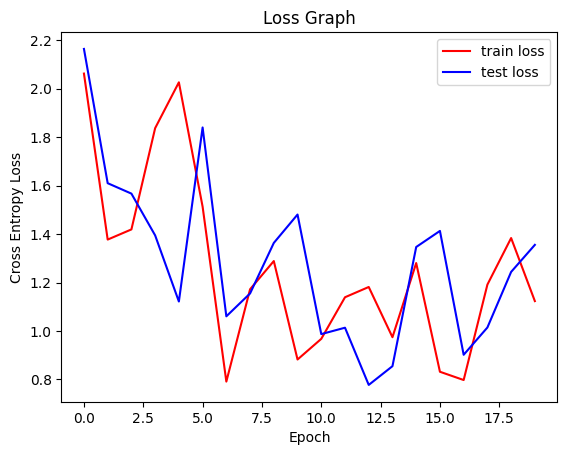

In [17]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [18]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

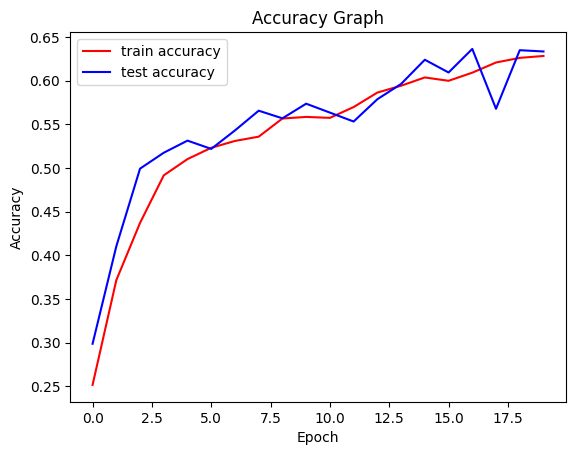

In [19]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [28]:
torch.save(model,'weather_image_baseline_classifier.pt')

## Fine-tuning pretrained image classification models

### AlexNet

In [20]:
alexnet = models.alexnet(pretrained=True)
alexnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 87.2MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
total_params = 0

for param in alexnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of the AlexNet model:", total_params)

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000
Total parameters of the AlexNet model: 61100840


In [26]:
alexnet.classifier = nn.Sequential(
    nn.Linear(9216,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,11),
    nn.LogSoftmax(dim=1)
)
alexnet = alexnet.cuda()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=alexnet.parameters(),lr=0.001)

In [29]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
        
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = alexnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = alexnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())
    
print(f"Total time elapsed in Alexnet model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 1.1976091861724854
Epoch 1 Batch 100 -> Loss: 1.1072055101394653
Epoch 1 Batch 150 -> Loss: 1.364129662513733
Epoch 2 Batch 50 -> Loss: 0.941400408744812
Epoch 2 Batch 100 -> Loss: 0.5832219123840332
Epoch 2 Batch 150 -> Loss: 0.9160119891166687
Epoch 3 Batch 50 -> Loss: 0.46500295400619507
Epoch 3 Batch 100 -> Loss: 0.75815749168396
Epoch 3 Batch 150 -> Loss: 0.4534215033054352
Epoch 4 Batch 50 -> Loss: 0.6814519166946411
Epoch 4 Batch 100 -> Loss: 0.658294141292572
Epoch 4 Batch 150 -> Loss: 1.2091064453125
Epoch 5 Batch 50 -> Loss: 0.390251100063324
Epoch 5 Batch 100 -> Loss: 0.7295544743537903
Epoch 5 Batch 150 -> Loss: 0.4818500280380249
Epoch 6 Batch 50 -> Loss: 0.5106977820396423
Epoch 6 Batch 100 -> Loss: 0.8625677824020386
Epoch 6 Batch 150 -> Loss: 0.8520455360412598
Epoch 7 Batch 50 -> Loss: 0.776658833026886
Epoch 7 Batch 100 -> Loss: 0.8655633330345154
Epoch 7 Batch 150 -> Loss: 0.6627687811851501
Epoch 8 Batch 50 -> Loss: 0.9109119176864624
Epoch

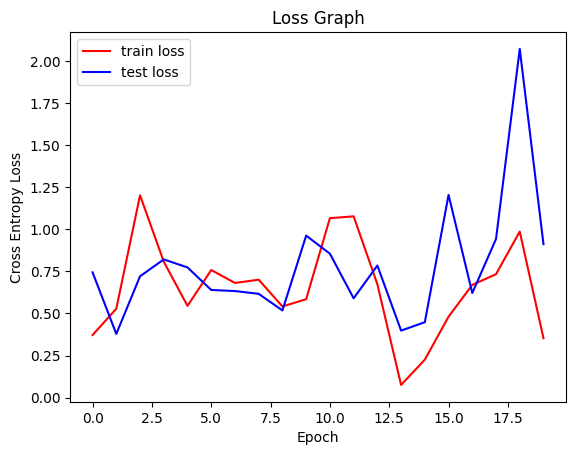

In [30]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

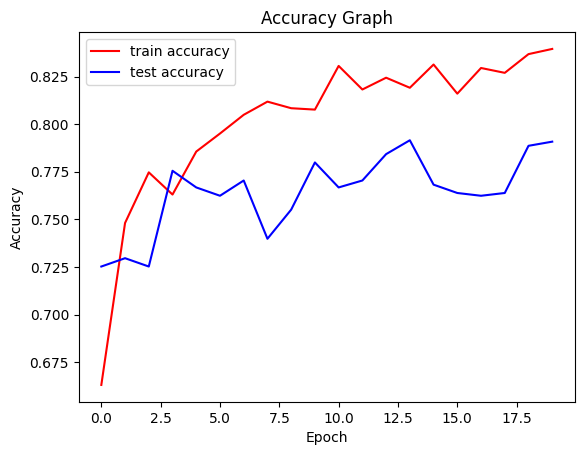

In [31]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [34]:
torch.save(alexnet,'weather_image_alexnet_classifier.pt')

### ResNet50

In [42]:
resnet = models.resnet50(pretrained=True)
resnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
total_params = 0

for param in resnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of pretrained ResNet50 model:", total_params)

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
524288
512
512
2359296
512
512
1048576
2048
2048
2097152
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
2048000
1000
Total parameters of pretrained ResNet50 model: 25557032


In [44]:
resnet.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,11),
    nn.LogSoftmax(dim=1)
)
resnet = resnet.cuda()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=resnet.parameters(),lr=0.001)

In [46]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
        
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = resnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = resnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())
    
print(f"Total time elapsed in ResNet50 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 1.1017073392868042
Epoch 1 Batch 100 -> Loss: 0.8974000215530396
Epoch 1 Batch 150 -> Loss: 0.8569934368133545
Epoch 2 Batch 50 -> Loss: 0.6621728539466858
Epoch 2 Batch 100 -> Loss: 0.6248372197151184
Epoch 2 Batch 150 -> Loss: 0.568652868270874
Epoch 3 Batch 50 -> Loss: 0.6704336404800415
Epoch 3 Batch 100 -> Loss: 0.3514697849750519
Epoch 3 Batch 150 -> Loss: 0.6121466755867004
Epoch 4 Batch 50 -> Loss: 0.6367183327674866
Epoch 4 Batch 100 -> Loss: 0.539665699005127
Epoch 4 Batch 150 -> Loss: 0.4833810329437256
Epoch 5 Batch 50 -> Loss: 0.7162491679191589
Epoch 5 Batch 100 -> Loss: 0.6220949292182922
Epoch 5 Batch 150 -> Loss: 0.6993980407714844
Epoch 6 Batch 50 -> Loss: 0.7474315166473389
Epoch 6 Batch 100 -> Loss: 0.6890320777893066
Epoch 6 Batch 150 -> Loss: 0.46317756175994873
Epoch 7 Batch 50 -> Loss: 0.3806209862232208
Epoch 7 Batch 100 -> Loss: 0.38547858595848083
Epoch 7 Batch 150 -> Loss: 0.8640010356903076
Epoch 8 Batch 50 -> Loss: 0.4776173233985

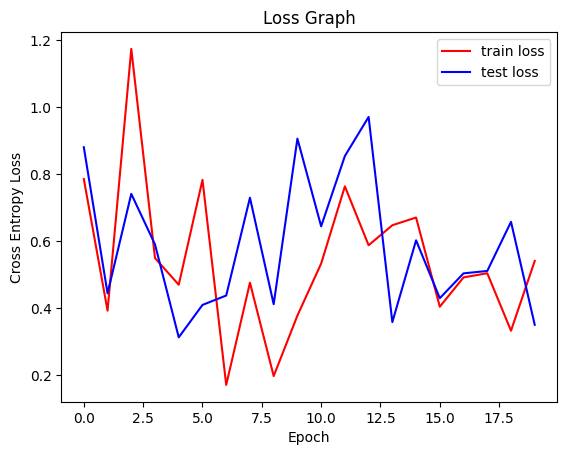

In [47]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

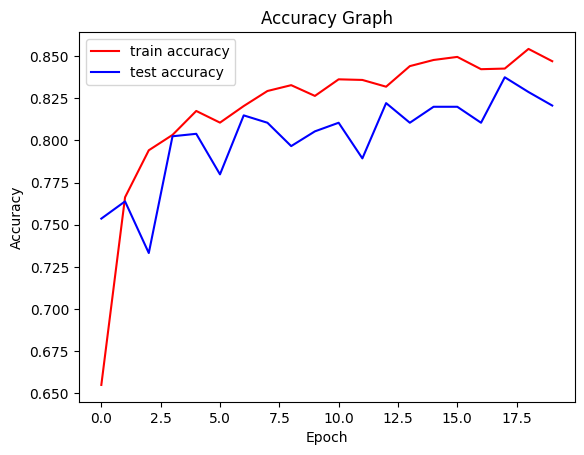

In [48]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [49]:
torch.save(resnet,'weather_image_resnet_classifier.pt')

### VGG16

In [56]:
vgg16 = models.vgg16(pretrained=True)
vgg16

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [57]:
total_params = 0

for param in vgg16.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of the pretrained VGG16 model:", total_params)

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000
Total parameters of the pretrained VGG16 model: 138357544


In [58]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(1024,11),
    nn.LogSoftmax(dim=1)
)

vgg16 = vgg16.cuda()
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=vgg16.parameters(),lr=0.001)

In [60]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
        
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = vgg16(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = vgg16(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())
    
print(f"Total time elapsed in VGG16 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 0.8008571267127991
Epoch 1 Batch 100 -> Loss: 0.8319656848907471
Epoch 1 Batch 150 -> Loss: 0.7867111563682556
Epoch 2 Batch 50 -> Loss: 0.3875836431980133
Epoch 2 Batch 100 -> Loss: 0.7193887233734131
Epoch 2 Batch 150 -> Loss: 0.4773451089859009
Epoch 3 Batch 50 -> Loss: 0.36504101753234863
Epoch 3 Batch 100 -> Loss: 0.9066190123558044
Epoch 3 Batch 150 -> Loss: 0.41458752751350403
Epoch 4 Batch 50 -> Loss: 0.5687655806541443
Epoch 4 Batch 100 -> Loss: 0.7126463651657104
Epoch 4 Batch 150 -> Loss: 0.23973646759986877
Epoch 5 Batch 50 -> Loss: 0.3546525537967682
Epoch 5 Batch 100 -> Loss: 0.6230400204658508
Epoch 5 Batch 150 -> Loss: 0.7975176572799683
Epoch 6 Batch 50 -> Loss: 0.21730409562587738
Epoch 6 Batch 100 -> Loss: 0.41346216201782227
Epoch 6 Batch 150 -> Loss: 0.2012528032064438
Epoch 7 Batch 50 -> Loss: 0.41277003288269043
Epoch 7 Batch 100 -> Loss: 0.6151853203773499
Epoch 7 Batch 150 -> Loss: 0.8204488158226013
Epoch 8 Batch 50 -> Loss: 0.6321208

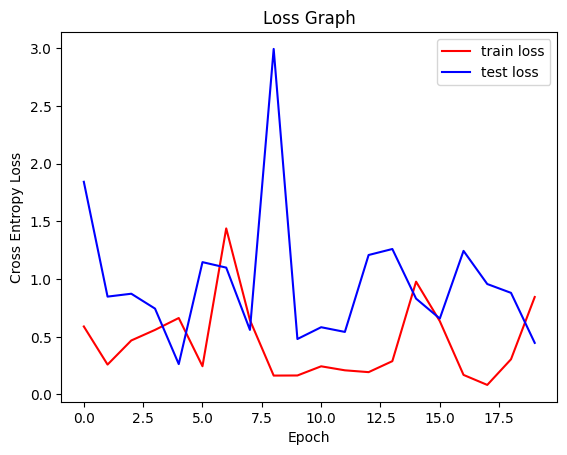

In [61]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

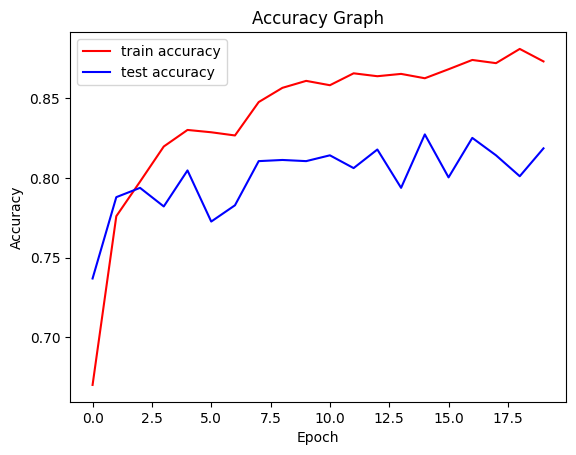

In [62]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [64]:
torch.save(vgg16,'weather_image_vgg16_classifier.pt')

### MobileNet v3 large

In [65]:
mobilenet = models.mobilenet_v3_large(pretrained=True)
mobilenet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 81.9MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [66]:
total_params = 0

for param in mobilenet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of Mobile Net v3 Large model:", total_params)

432
16
16
144
16
16
256
16
16
1024
64
64
576
64
64
1536
24
24
1728
72
72
648
72
72
1728
24
24
1728
72
72
1800
72
72
1728
24
1728
72
2880
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
9600
240
240
2160
240
240
19200
80
80
16000
200
200
1800
200
200
16000
80
80
14720
184
184
1656
184
184
14720
80
80
14720
184
184
1656
184
184
14720
80
80
38400
480
480
4320
480
480
57600
120
57600
480
53760
112
112
75264
672
672
6048
672
672
112896
168
112896
672
75264
112
112
75264
672
672
16800
672
672
112896
168
112896
672
107520
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
1228800
1280
1280000
1000
Total parameters of Mobile Net v3 Large model: 5483032


In [67]:
mobilenet.classifier = nn.Sequential(
    nn.Linear(960,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,11),
    nn.LogSoftmax(dim=1)
)

mobilenet = mobilenet.cuda()
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=mobilenet.parameters(),lr=0.001)

In [69]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
        
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = mobilenet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = mobilenet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())
    
print(f"Total time elapsed in MobileNet v3 large model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 1.0600072145462036
Epoch 1 Batch 100 -> Loss: 0.6575243473052979
Epoch 1 Batch 150 -> Loss: 0.8572885990142822
Epoch 2 Batch 50 -> Loss: 0.4712989330291748
Epoch 2 Batch 100 -> Loss: 0.6939415335655212
Epoch 2 Batch 150 -> Loss: 0.9160395264625549
Epoch 3 Batch 50 -> Loss: 0.4125311076641083
Epoch 3 Batch 100 -> Loss: 0.8431558012962341
Epoch 3 Batch 150 -> Loss: 0.6388611197471619
Epoch 4 Batch 50 -> Loss: 0.38630640506744385
Epoch 4 Batch 100 -> Loss: 0.4979560077190399
Epoch 4 Batch 150 -> Loss: 0.5257158279418945
Epoch 5 Batch 50 -> Loss: 0.46608033776283264
Epoch 5 Batch 100 -> Loss: 0.3820449411869049
Epoch 5 Batch 150 -> Loss: 0.5190939903259277
Epoch 6 Batch 50 -> Loss: 0.23573707044124603
Epoch 6 Batch 100 -> Loss: 1.0172735452651978
Epoch 6 Batch 150 -> Loss: 0.5473194122314453
Epoch 7 Batch 50 -> Loss: 0.6507664918899536
Epoch 7 Batch 100 -> Loss: 0.5228126049041748
Epoch 7 Batch 150 -> Loss: 0.42309755086898804
Epoch 8 Batch 50 -> Loss: 0.247136175

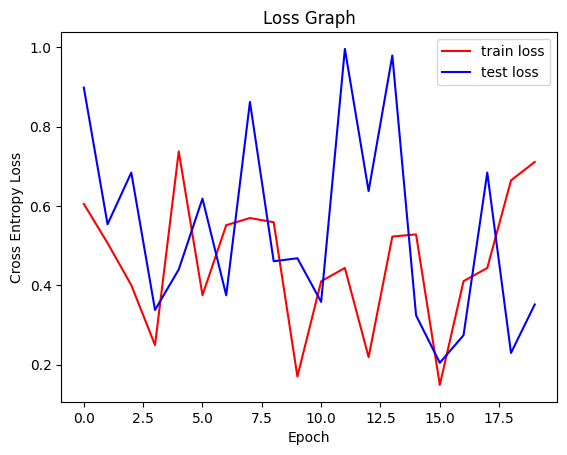

In [70]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

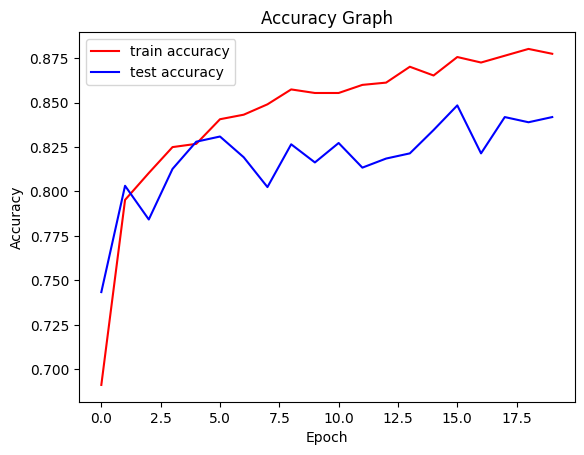

In [71]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [72]:
torch.save(mobilenet,'weather_image_mobilenet_classifier.pt')

In [74]:
torch.cuda.memory_allocated()

2332515840

In [75]:
torch.cuda.memory_reserved()

6501171200

Among all pretrained models used, the MobileNet v3 large model achieved the best performance having attained a stupendous accuracy score of more than 82.5% on the test set. The MobileNet v3 model is comptutationally efficient as well as it is suitable for use in even mobile devices and can achieve performance comparable with other SOTA pre-trained image classification models. It is closely followed by the ResNet50 model which achieved an amazing accuracy score of a little over 82% on the test set. 